In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# handles loading tool kit in .py format from another notebook
import sys
import os
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Coursera - EDHEC - Intro to Portfolio Construction with Python/')

**1) The Efficient Frontier**

In [4]:
path = '/content/drive/MyDrive/Colab Notebooks/Coursera - EDHEC - Intro to Portfolio Construction with Python/ind30_m_ew_rets.csv'

In [5]:
ind = pd.read_csv(path, header=0, index_col=0, parse_dates=True)/100
ind.index = pd.to_datetime(ind.index, format='%Y%m').to_period('M')

In [6]:
ind.head(3)

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.0086,-0.0536,0.0167,0.0231,0.2628,0.0245,-0.0068,0.0245,0.0101,0.0044,...,0.0131,0.0776,0.0313,0.0129,-0.0089,-0.2023,0.0178,0.0169,0.0044,0.0261
1926-08,0.0370,0.1925,0.0501,0.0253,0.2118,-0.0286,0.0479,0.0611,0.0302,0.0431,...,0.0108,0.0420,0.0120,0.0400,0.0513,0.0942,-0.0045,-0.0090,0.0884,0.0348
1926-09,0.0138,0.0563,0.0310,0.0413,-0.0204,0.0176,-0.0616,0.0080,0.0240,-0.0409,...,0.0022,-0.0628,-0.0089,-0.0664,-0.0028,0.0032,-0.0087,-0.0014,-0.0255,-0.0018


In [7]:
ind.columns #there are embedded space in the column header names

Index(['Food ', 'Beer ', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth ',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal ', 'Oil  ', 'Util ', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin  ', 'Other'],
      dtype='object')

In [8]:
ind.columns = ind.columns.str.strip()

In [9]:
def get_ind_returns():
  ind = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Coursera - EDHEC - Intro to Portfolio Construction with Python/ind30_m_vw_rets.csv',
                    header=0, index_col=0, parse_dates=True)/100
  ind.index = pd.to_datetime(ind.index, format='%Y%m').to_period('M')
  ind.columns = ind.columns.str.strip()
  return ind

In [10]:
#Refresh
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [11]:
import edhec_risk_kit as erk

In [12]:
ind = erk.get_ind_returns()
ind.shape

(1110, 30)

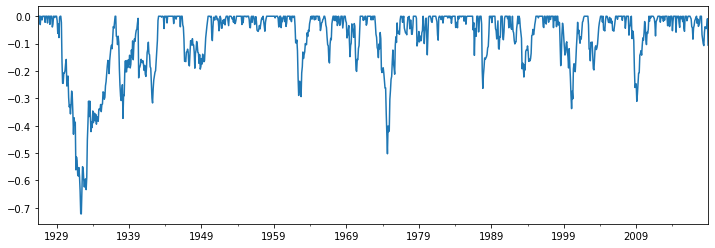

In [13]:
erk.drawdown(ind['Food'])['Drawdowns'].plot.line(figsize=(12,4))

In [14]:
erk.var_gaussian(ind[['Food', 'Smoke', 'Coal', 'Beer', 'Fin']], modified=True)

Food     0.061207
Smoke    0.080292
Coal     0.047359
Beer     0.033881
Fin      0.075199
dtype: float64

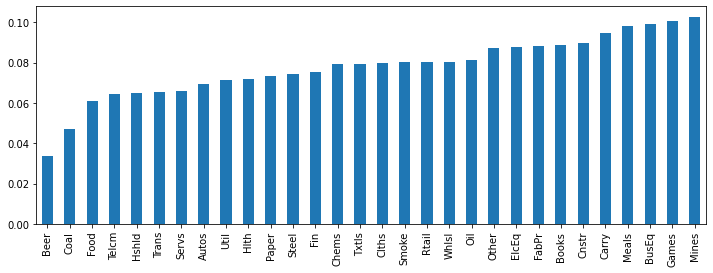

In [15]:
erk.var_gaussian(ind, modified=True).sort_values().plot.bar(figsize=(12, 4))

Annualized return/ vol toolkit - 

In [16]:
def annualize_rets(r, periods_per_year):
  # calculate annualized returns
  compounded_growth = (1+r).prod()
  n_periods = r.shape[0]
  return compounded_growth**(periods_per_year/n_periods)-1

In [17]:
def annualize_vol(r, periods_per_year):
  #annualize vol for set of returns
  return r.std()*(periods_per_year**0.5)

In [18]:
def sharpe_ratio(r, riskfree_rate, periods_per_year):
  # convert the annual riskfree rate to per period, compute annualized sharpe ratio for set of returns
  rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
  excess_ret = r - rf_per_period
  ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
  ann_vol = annualize_vol(r, periods_per_year)
  return ann_ex_ret/ann_vol

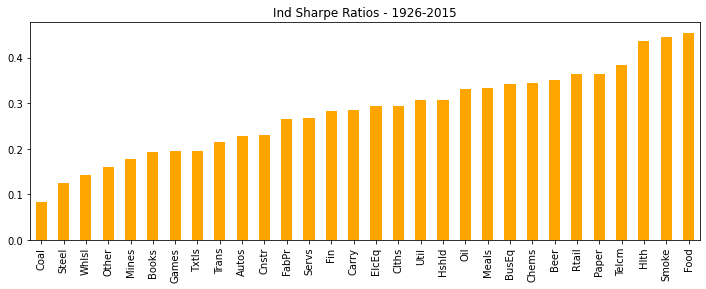

In [19]:
erk.sharpe_ratio(ind, 0.03, 12).sort_values().plot.bar(title='Ind Sharpe Ratios - 1926-2015', color='orange', figsize=(12, 4))

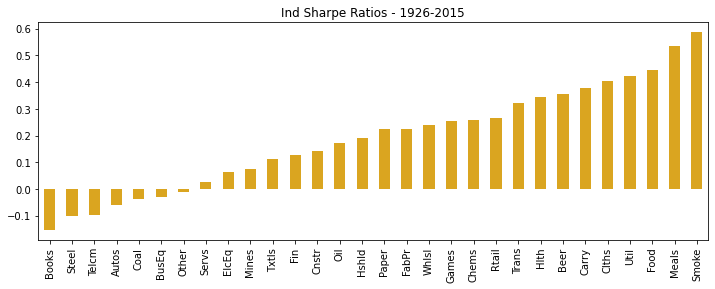

In [20]:
erk.sharpe_ratio(ind['2000':], 0.03, 12).sort_values().plot.bar(title='Ind Sharpe Ratios - 1926-2015', color='goldenrod', figsize=(12, 4))

In [21]:
er = erk.annualize_rets(ind['1995':'2000'], 12)

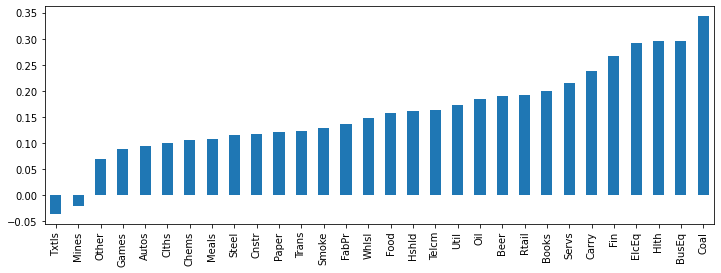

In [22]:
er.sort_values().plot.bar(figsize=(12,4))

In [23]:
cov = ind['1995':'2000'].cov()
cov.shape

(30, 30)

Plotting the efficient frontier

In [24]:
ind = erk.get_ind_returns()
er = erk.annualize_rets(ind['1996':'2000'], 12)
cov = ind['1996':'2000'].cov()

In [25]:
def portfolio_return(weights, returns):
  # weights to returns
  return weights.T @ returns 

In [26]:
def portfolio_vol(weights, covmat):
  # weights to vol
  return (weights.T @ covmat @ weights)**0.5

In [27]:
l = ['Food', 'Beer', 'Smoke', 'Coal']
er[l]

Food     0.116799
Beer     0.141126
Smoke    0.107830
Coal     0.414689
dtype: float64

In [28]:
cov.loc[l, l]

,Food,Beer,Smoke,Coal
Food,0.002609,0.002379,0.002061,0.000027
Beer,0.002379,0.005264,0.001359,0.001728
Smoke,0.002061,0.001359,0.008349,-0.000733
Coal,0.000027,0.001728,-0.000733,0.018641


In [29]:
weights = np.repeat(1/4, 4)
erk.portfolio_return(weights, er[l])

0.19511097196038385

In [30]:
erk.portfolio_vol(weights, cov.loc[l,l])

0.055059195776437045

2 Asset Frontier

In [31]:
#portfolio list - 2 asset
l = ['Games', 'Fin']

In [32]:
n_points = 20
weights = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_points) ] # 0.1, 0.9 - basically loop list comprehension

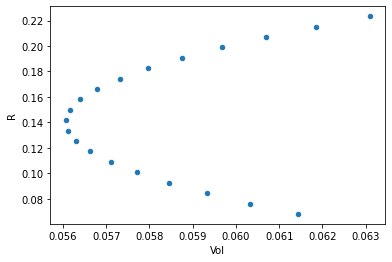

In [33]:
rets = [erk.portfolio_return(w, er[l]) for w in weights]
vols = [erk.portfolio_vol(w, cov.loc[l,l]) for w in weights] 
ef = pd.DataFrame({'R': rets, 'Vol': vols})
ef.plot.scatter(x='Vol', y='R')

In [34]:
def plot_ef2(n_points, er, cov):
  #plot 2 asset efficient frontier 
  if er.shape[0] != 2 or er.shape[0] != 2:
    raise ValueError("plot_ef2 can only plot 2-asset frontiers")
  weights = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_points)]
  rets = [portfolio_return(w, er) for w in weights]
  vols = [portfolio_vol(w, cov) for w in weights]
  ef = pd.DataFrame({
    "Returns": rets, 
    "Volatility": vols
    })
  return ef.plot.line(x="Volatility", y="Returns", style=".-")

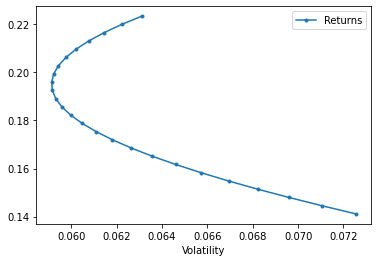

In [35]:
l = ['Fin', 'Beer']
erk.plot_ef2(25, er[l], cov.loc[l,l])

**N-Asset(s) Efficient Frontier**

In [36]:
from scipy.optimize import minimize

In [44]:
def minimize_vol(target_return, er, cov):
  # get target return to weights
  n = er.shape[0]
  init_guess = np.repeat(1/n, n)
  bounds = ((0.0, 1.0),)*n #put a tuple of tuples
  return_is_target = {
      'type'  : 'eq',
      'args'  : (er, ),
      'fun'   : lambda weights, er: target_return - erk.portfolio_return(weights, er)
  }
  weights_sum_to_1= {
      'type'  : 'eq',
      'fun'   : lambda weights: np.sum(weights) -1
  }
  results = minimize(erk.portfolio_vol, init_guess,
                     args=(cov,), method='SLSQP',
                     options={'disp': False},
                     constraints=(return_is_target, weights_sum_to_1),
                     bounds=bounds)
  return results.x

In [47]:
l = ['Games', 'Fin']

In [51]:
w15 = erk.minimize_vol(0.15, er[l], cov.loc[l,l])
vol15 = erk.portfolio_vol(w15, cov.loc[l,l])
vol15

0.056163669406706564

In [49]:
w15 # asset allocation weights

array([0.47287631, 0.52712369])

In [54]:
def optimal_weights(n_points, er, cov):
    """
    Returns a list of weights that represent a grid of n_points on the efficient frontier
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

def plot_ef(n_points, er, cov, style='.-', legend=False, show_cml=False, riskfree_rate=0, show_ew=False, show_gmv=False):
    """
    Plots the multi-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov)
    rets = [erk.portfolio_return(w, er) for w in weights]
    vols = [erk.portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x='Volatility', y='Returns', style='.-')

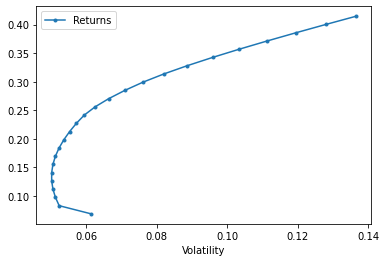

In [56]:
l = ['Smoke', 'Fin', 'Games', 'Coal']
erk.plot_ef(25, er[l], cov.loc[l,l])